In [555]:
import pandas as pd
import numpy as np

In [556]:
robberies_in_boston = pd.read_csv("monthly-boston-armed-robberies-j.csv")
mean_monthly_temp = pd.read_csv("mean-monthly-air-temperature-deg.csv")

In [557]:
import matplotlib.pyplot as plt
%matplotlib inline

In [558]:
all_series = {
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
   }

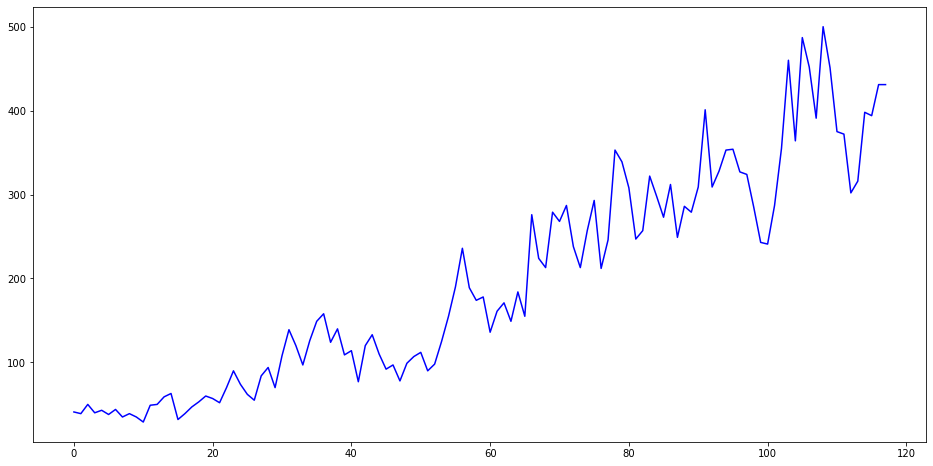

In [559]:
plt.figure(figsize=(16, 8))
plt.plot(all_series["Monthly Boston armed robberies"], color='blue')

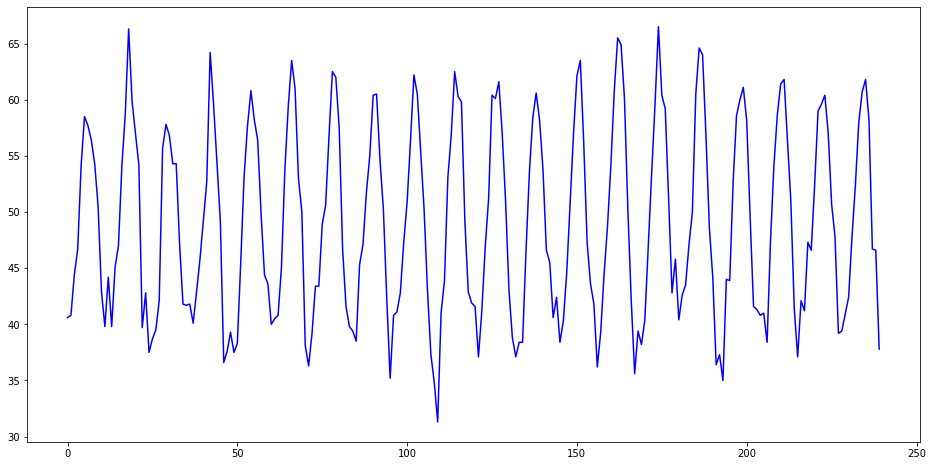

In [560]:
plt.figure(figsize=(16, 8))
plt.plot(all_series["Mean monthly air temperature (Deg. F) Nottingham Castle"], color='blue')

In [561]:
################
 # Dickey-Fuller
##################
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [562]:
from statsmodels.tsa.stattools import adfuller

In [563]:
test_stationarity(all_series["Monthly Boston armed robberies"])

Results of Dickey-Fuller Test:
Test Statistic                   1.001102
p-value                          0.994278
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


In [564]:
test_stationarity(all_series["Mean monthly air temperature (Deg. F) Nottingham Castle"])

Results of Dickey-Fuller Test:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


In [565]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [566]:
series = all_series["Monthly Boston armed robberies"]

In [567]:
train, val = series[:85], series[85:]

In [568]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [569]:
def exponential_moving_average_with_preds(series, alpha, n_pred):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
       
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]
    preds = []
    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
        preds.append(res)
    
    return result, preds

In [570]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [571]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
           
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return result, preds

In [572]:
def initial_trend(series, season_len, i):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [573]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [574]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen, i)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [575]:
from sklearn.model_selection import TimeSeriesSplit

In [576]:
def mse_cross_val_1(X):
    alpha = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
#         print(train_split_ts)
#         print(test_split_ts)
        result = exponential_moving_average(train_split_ts, alpha)
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [577]:
def mse_cross_val_2(X):
    alpha, beta = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
#         print(train_split_ts)
#         print(test_split_ts)
        result = double_ema(train_split_ts, alpha, beta)
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [578]:
def mse_cross_val_3(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
#         print(train_split_ts)
#         print(test_split_ts)
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [579]:
def plot_tema_1(alpha, ser, ser_to_plot, n_preds):
    tema, pred = exponential_moving_average_with_preds(ser, alpha, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='EMA')
        plt.title("alpha={}".format(alpha))
        plt.legend()

In [580]:
def plot_tema_2(alpha, beta, ser, ser_to_plot, n_preds):
    tema, pred = double_ema_with_preds(ser, alpha, beta, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

In [581]:
def plot_tema_3(alpha, beta, gamma, ser, ser_to_plot, n_preds):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

In [582]:
opt_1 = minimize(mse_cross_val_1, x0=[0], method="Nelder-Mead")


22092.95238095238------------
21993.18867336639------------
21894.377291273853------------
21796.50728856331------------
21603.548356551724------------
21414.227157949706------------
21046.170071107797------------
20691.701342430333------------
20021.15041253594------------
19398.112775621026------------
18278.866403704586------------
17306.187468974018------------
15713.459611458791------------
14481.366472340209------------
12744.538566936244------------
11618.327396405564------------
10309.906324602092------------
9604.144607608214------------
8875.29033840838------------
8501.85591435923------------
8143.626547999128------------
8004.605769726565------------
7955.528620485937------------
8016.319447158676------------
8016.319447158676------------
7957.930942735576------------
7977.616073537504------------
7952.827524954297------------
7957.930942735576------------
7953.337246091837------------
7954.2534245366705------------
7952.857609375584------------
7953.280382693979-----------

In [583]:
alpha_opt = opt_1.x
print(opt_1)

 final_simplex: (array([[0.7106875],
       [0.710625 ]]), array([7952.78330974, 7952.7833114 ]))
           fun: 7952.783309741392
       message: 'Optimization terminated successfully.'
          nfev: 48
           nit: 24
        status: 0
       success: True
             x: array([0.7106875])


C:\Users\Sasha\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


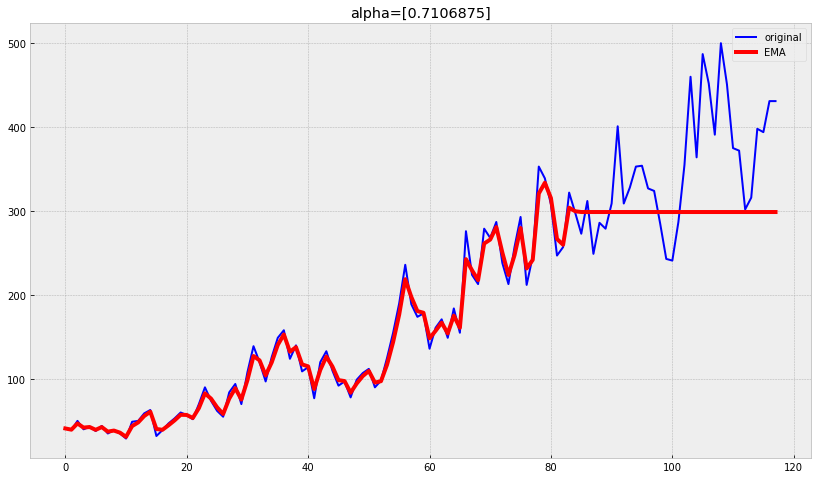

In [584]:
plot_tema_1(alpha_opt, ser=train, ser_to_plot=series, n_preds=len(val))

In [585]:
tema, pred = exponential_moving_average_with_preds(train, alpha_opt, len(val))

In [586]:
error = mean_squared_error(pred, val)
print(error)

7852.187053662655


In [587]:
opt_2 = minimize(mse_cross_val_2, x0=[0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1)))

49406.47619047619------------
49059.341389891786------------
49406.47619047619------------
49059.341389891786------------
48716.211175830045------------
48377.03015681597------------
48377.03015681597------------
47710.298464722415------------
47058.72028181794------------
47058.72028181794------------
45799.38583334573------------
44595.87447728752------------
44595.87447728752------------
42344.651658201954------------
40283.42283980796------------
40283.42283980796------------
36656.57530813635------------
33586.77810259973------------
33586.77810259973------------
28732.93831133438------------
25132.53511237797------------
25132.535112377966------------
22404.813385193254------------
18641.641106358496------------
15783.274114440492------------
14979.604105752345------------
13138.13165164474------------
11661.029115198597------------
10468.677207507137------------
9994.248031637208------------
9308.180984809069------------
8881.34941924161------------
8534.728805093886------------

In [588]:
alpha_opt, beta_opt = opt_2.x
print(opt_2)

 final_simplex: (array([[1., 0.],
       [1., 0.],
       [1., 0.]]), array([8298.76190476, 8298.76190476, 8298.76190476]))
           fun: 8298.761904761906
       message: 'Optimization terminated successfully.'
          nfev: 40
           nit: 23
        status: 0
       success: True
             x: array([1., 0.])


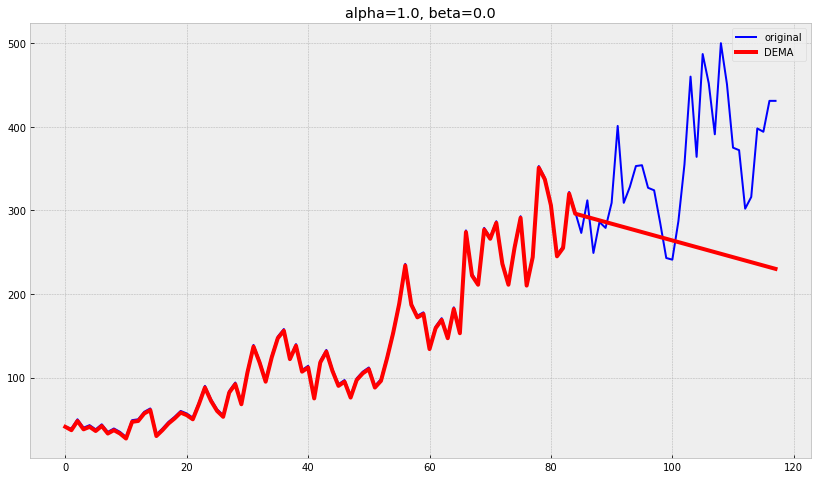

In [589]:
plot_tema_2(alpha_opt, beta_opt, ser=train, ser_to_plot=series, n_preds=len(val))

In [590]:
tema, pred = double_ema_with_preds(train, alpha_opt, beta_opt, len(val))

In [591]:
error = mean_squared_error(pred, val)
print(error)

15090.030303030304


In [592]:
opt_3 = minimize(mse_cross_val_3, x0=[0,0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1), (0, 1)))

20633.998773240008------------
20493.89913709948------------
20633.998773240008------------
20622.70934107556------------
20532.940798129126------------
20466.047721115265------------
20382.965614858782------------
20318.81448498166------------
20169.832291709095------------
20166.20648610886------------
19987.175116809056------------
19872.24499053309------------
19573.859053116015------------
19451.534518580258------------
19014.12554850683------------
18902.517807163233------------
18321.89267835664------------
18020.27310502932------------
17166.294434838703------------
16885.645532233462------------
15791.153654365198------------
15412.605750952527------------
14078.214892913811------------
13548.220907645215------------
12025.764561849695------------
11568.94915270771------------
10074.355049498903------------
9597.812727865135------------
8296.629328501394------------
7909.169571875802------------
6916.520499502254------------
6655.060719102745------------
5963.2224459308445----

In [593]:
alpha_opt, beta_opt, gamma_opt = opt_3.x
print(opt_3)

 final_simplex: (array([[0.85386064, 0.        , 1.        ],
       [0.85393236, 0.        , 1.        ],
       [0.85383459, 0.        , 1.        ],
       [0.85395432, 0.        , 1.        ]]), array([4853.38682756, 4853.38683114, 4853.38684222, 4853.38684514]))
           fun: 4853.386827555981
       message: 'Optimization terminated successfully.'
          nfev: 175
           nit: 95
        status: 0
       success: True
             x: array([0.85386064, 0.        , 1.        ])


plot_tema_3(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))

In [594]:
tema = triple_exponential_smoothing(train, 12, alpha_opt, beta_opt, gamma_opt, len(val))

In [595]:
pred = tema[-len(val):]

In [596]:
error = mean_squared_error(pred, val)
print(error)

6616.04511441035


Рассмотрли 3 подхода: экспоненциальное сглаживание, двойное экспоненциальное сглаживание и метод Хольт-Винтерса. Наилучший результат для последнего 

# Для стационарного ряда

In [597]:
series = all_series["Mean monthly air temperature (Deg. F) Nottingham Castle"]

In [598]:
train, val = series[:85], series[85:]

In [599]:
opt_1 = minimize(mse_cross_val_1, x0=[0], method="Nelder-Mead")

122.63730158730158------------
121.5321370235716------------
120.44939892076509------------
119.38856161823033------------
117.33055176215136------------
115.35415750326335------------
111.63137339648596------------
108.19230597293563------------
102.06671218928129------------
96.80269788399487------------
88.31146276363161------------
81.85038420647491------------
72.84058465949597------------
66.9267765967838------------
59.51818058095672------------
54.769431039954014------------
48.33586386762382------------
43.871433198747354------------
38.915065175269405------------
38.7298940507097------------
49.452184264652665------------
38.915065175269405------------
42.60917620924121------------
38.25852996752318------------
38.915065175269405------------
38.35899934564069------------
38.44060728343445------------
38.274151742836295------------
38.3135810477153------------
38.25759384187811------------
38.274151742836295------------
38.25586391171641------------
38.25852996752318----------

In [600]:
alpha_opt = opt_1.x
print(opt_1)

 final_simplex: (array([[0.2259375],
       [0.226    ]]), array([38.25583969, 38.2558402 ]))
           fun: 38.25583969097073
       message: 'Optimization terminated successfully.'
          nfev: 42
           nit: 21
        status: 0
       success: True
             x: array([0.2259375])


C:\Users\Sasha\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


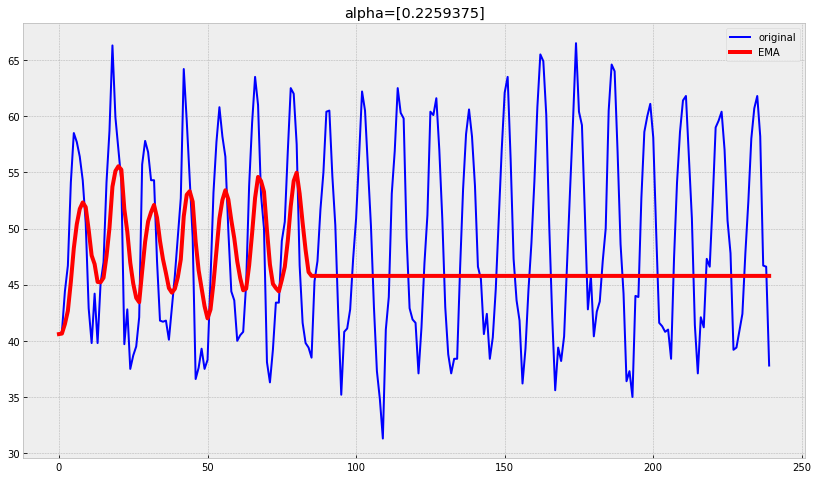

In [601]:
plot_tema_1(alpha_opt, ser=train, ser_to_plot=series, n_preds=len(val))

In [602]:
tema, pred = exponential_moving_average_with_preds(train, alpha_opt, len(val))

In [603]:
error = mean_squared_error(pred, val)
print(error)

88.5347189692017


In [604]:
opt_2 = minimize(mse_cross_val_2, x0=[0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1)))

74.70079365079347------------
74.61184065869355------------
74.70079365079347------------
74.61184065869355------------
74.52406441735195------------
74.43739835342784------------
74.43739835342784------------
74.26714449297161------------
74.10060121945106------------
74.10060121945106------------
73.77693495876667------------
73.46333764724093------------
73.46333764724093------------
72.85663569490613------------
72.26517664356707------------
72.26517664356707------------
71.09185941385402------------
69.90335589072164------------
69.90335589072164------------
67.46516018181269------------
65.01283494481605------------
65.01283494481605------------
60.38908635148141------------
56.35765765984157------------
56.35765765984154------------
52.91012685856206------------
47.42201728419972------------
42.658988174820166------------
41.336136255094715------------
39.20430033012793------------
41.20644632574007------------
47.21788757160323------------
39.51666000211652------------
44.77336

In [605]:
alpha_opt, beta_opt = opt_2.x
print(opt_2)

 final_simplex: (array([[0.228875 , 0.       ],
       [0.228875 , 0.       ],
       [0.2289375, 0.       ]]), array([39.15739905, 39.15739905, 39.15739969]))
           fun: 39.15739904904402
       message: 'Optimization terminated successfully.'
          nfev: 62
           nit: 37
        status: 0
       success: True
             x: array([0.228875, 0.      ])


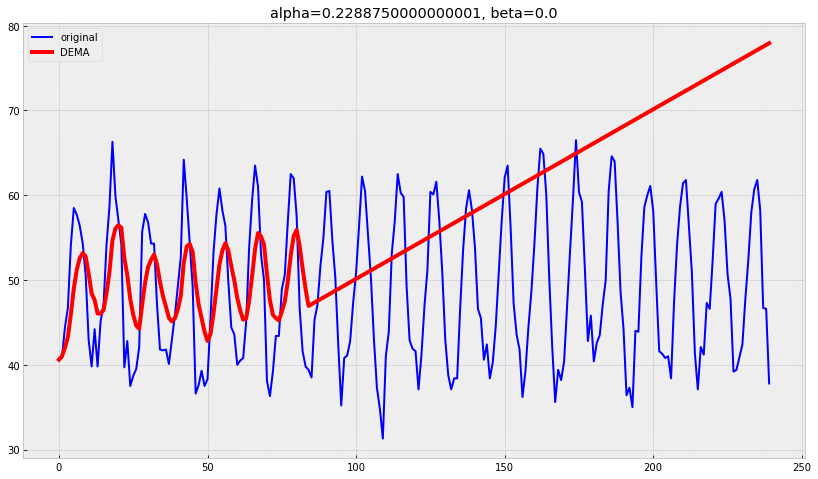

In [606]:
plot_tema_2(alpha_opt, beta_opt, ser=train, ser_to_plot=series, n_preds=len(val))

In [607]:
tema, pred = double_ema_with_preds(train, alpha_opt, beta_opt, len(val))

In [608]:
error = mean_squared_error(pred, val)
print(error)

324.6929585506093


In [609]:
opt_3 = minimize(mse_cross_val_3, x0=[0,0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1), (0, 1)))

47.21943192239929------------
46.19309517366784------------
47.21943192239929------------
47.13407545008774------------
46.4762213753577------------
45.98853532019579------------
45.38754355722897------------
44.930206587583655------------
43.875211835403405------------
43.849063974017724------------
42.60326092913184------------
41.813969358523025------------
39.81460547419957------------
39.0182072830869------------
36.24824096601758------------
35.560436208727275------------
32.1418128554513------------
30.46088560544956------------
26.045269370117182------------
24.70664245663387------------
19.974620704743835------------
18.513789826824752------------
14.085709328843897------------
12.624345264336673------------
9.302060417728443------------
8.55240911273894------------
6.876457612676187------------
6.596298435089401------------
6.556100730271624------------
6.784190485112767------------
7.634189277241681------------
6.9178911753715004------------
6.767590277588496------------
7.0

In [610]:
alpha_opt, beta_opt, gamma_opt = opt_3.x
print(opt_3)

 final_simplex: (array([[0.03766447, 0.        , 0.13773091],
       [0.03764798, 0.        , 0.13780573],
       [0.03766193, 0.        , 0.13767782],
       [0.03765143, 0.        , 0.13773612]]), array([6.31376639, 6.31376642, 6.31376643, 6.31376652]))
           fun: 6.313766386017959
       message: 'Optimization terminated successfully.'
          nfev: 203
           nit: 109
        status: 0
       success: True
             x: array([0.03766447, 0.        , 0.13773091])


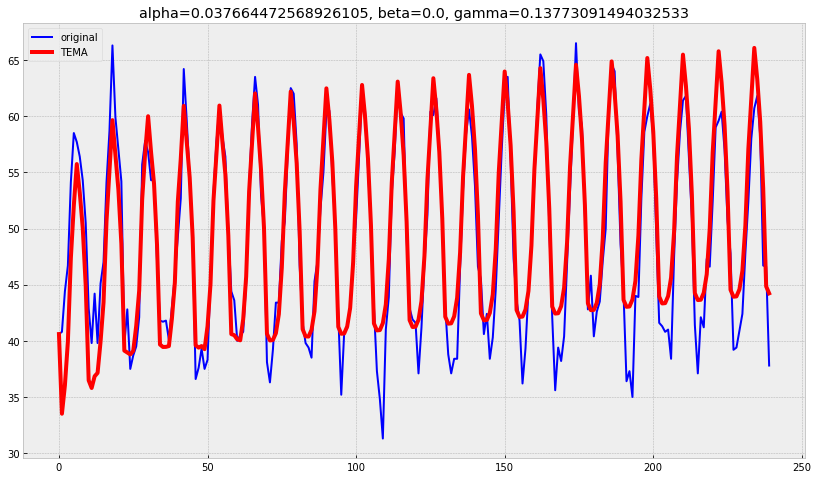

In [611]:
plot_tema_3(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))

In [612]:
tema = triple_exponential_smoothing(train, 12, alpha_opt, beta_opt, gamma_opt, len(val))

In [613]:
pred = tema[-len(val):]

In [614]:
error = mean_squared_error(pred, val)
print(error)

10.199639711010962


Рассмотрли 3 подхода: экспоненциальное сглаживание, двойное экспоненциальное сглаживание и метод Хольт-Винтерса. Наилучший результат для последнего 